In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from gym import wrappers

![features](src/mountaincar.jpg)

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
env.observation_space, env.action_space

(Box(-1.2000000476837158, 0.6000000238418579, (2,), float32), Discrete(3))

![features](src/features.jpg)

In [4]:
def feature_generator(state, action):
    x_p = 7 * (state[1] + 0.07) / 0.14
    y_p = 7 * (state[0] + 1.2) / 1.8
    d = 0.125
    feature_vector = np.zeros((3,8,8,8))
    
    for t in range(8):
        a = int(x_p - t * d + 1)
        b = int(y_p + t * d)        
        feature_vector[action, t, a, b] = 1
    return feature_vector


In [5]:
def show_tiles(state):
    
    x = 7 * (state[1] + 0.07) / 0.14
    y = 7 * (state[0] + 1.2) / 1.8
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xticks(range(-1,9,1))
    ax.set_yticks(range(-1,9,1))
    ax.set_xlim([-2, 9])
    ax.set_ylim([-2, 9])

    for t in range(8):
        for s in range(9):
            ax.plot([s + t * 0.125 - 1, s + t * 0.125 - 1], [0 - t * 0.125, 8 - t * 0.125], 'deepskyblue', linewidth=.5)
            ax.plot([-1 + t * 0.125, 7 + t * 0.125], [s - t * 0.125, s - t * 0.125], 'deepskyblue', linewidth=.5)

    ax.plot([x], [y], marker='o', markersize=3, color="crimson")

    ax.set_box_aspect(1)
    # set the x-spine (see below for more info on `set_position`)
    ax.spines['left'].set_position('zero')

    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()

    plt.show()

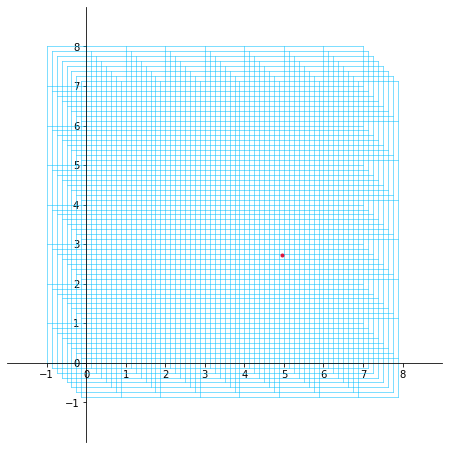

In [6]:
sample_state = [-0.5, 0.029] # pos, vel
show_tiles(sample_state)

In [7]:
f = feature_generator(sample_state, 0)[0]
x = np.where(f == 1)
for i in range(8):
    print(f"tiling {i}: tile:{(x[1][i],x[2][i])} ")


tiling 0: tile:(5, 2) 
tiling 1: tile:(5, 2) 
tiling 2: tile:(5, 2) 
tiling 3: tile:(5, 3) 
tiling 4: tile:(5, 3) 
tiling 5: tile:(5, 3) 
tiling 6: tile:(5, 3) 
tiling 7: tile:(5, 3) 


In [8]:
class SemiGradientSARSA:
    def __init__(self, gamma=1, alpha=1e-2, epsilon=0.1):
        self.w = np.zeros((3,8,8,8))
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        
    def estimate(self, n_episodes):
        for i in tqdm(range(n_episodes)):
            s = env.reset() #[pos, vel]
            a = self.policy(s)
            while True:
                s_p, reward, done, _ = env.step(a)
                a_p = self.policy(s_p)

                q_p = np.sum(self.w * feature_generator(s_p, a_p))
                q = np.sum(self.w * feature_generator(s, a))
                self.w += self.alpha * (reward + self.gamma * q_p - q) * feature_generator(s, a)

                if done:
                    break
                s = s_p
                a = a_p
            
    def policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        actions=[0,1,2]
        f = feature_generator(state, actions)
        q = self.w * f
        return np.argmax(q.reshape(3,-1).sum(axis=1))
    
    def cost_to_go(self, X, Y):
        Z = np.zeros(X.shape)
        concatenated = np.concatenate([X.ravel()[:,np.newaxis], Y.ravel()[:,np.newaxis]], axis=1)
        for i, k in enumerate(concatenated):
            q = self.w * feature_generator(k, [0,1,2])
            Z[i//X.shape[1],i%X.shape[1]] = np.max(q.reshape(3,-1).sum(axis=1))
        Z *= -1
        return Z

100%|██████████| 10000/10000 [03:23<00:00, 49.14it/s]


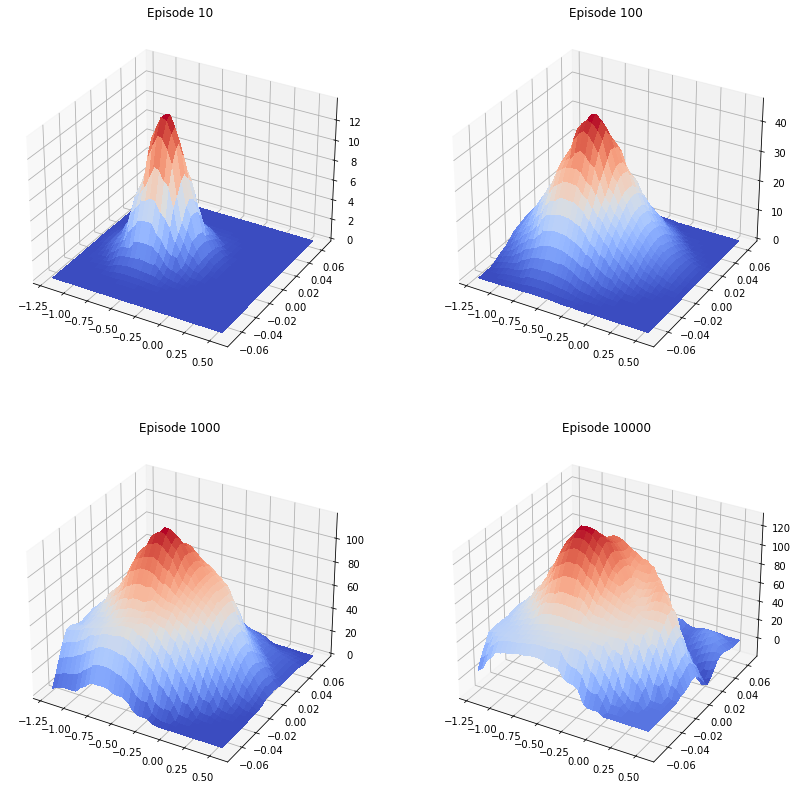

In [9]:
runs = [10, 100, 1000, 10000]
fig = plt.figure(figsize=(14, 14))
vel = np.arange(-0.07, 0.069, 0.005)
pos = np.arange(-1.2, 0.6, 0.05)
X, Y = np.meshgrid(pos, vel)

for i,r in enumerate(runs):
    sg_sarsa = SemiGradientSARSA()
    sg_sarsa.estimate(r)
    Z = sg_sarsa.cost_to_go(X, Y)
    
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
    ax.set_title('Episode ' + str(r))

plt.show()

In [10]:
sg_sarsa.epsilon = 0

env = gym.make('MountainCar-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
s = env.reset()
for _ in range(2000):
    action = sg_sarsa.policy(s)
    s_p, reward, done, info = env.step(action)
    if done: 
        break
    s = s_p
env.close()

In [11]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))